# Visualizing migration related news in Germany 2023 from newspaper headlines (2023)

The headlines come from a database, which tracks newspaper articles in German nationwide
and regional newspapers. I drew a sample of two days per week, for which all search results for the search string "migration",
published in the German press and relating to Germany, were retrieved. The article content itself is not available,
newspaper information and headlines are.
I saved the sampled search results as text files. This file shows the process of data cleaning and visualizing the
content of the headlines as word clouds (complete year and monthly).


In [1]:
## Packages ##
import io
from os import listdir
from os.path import isfile, join
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import re
from itertools import filterfalse
from wordcloud import WordCloud, STOPWORDS

## Creating a metadata file

In order to plot the general trend of migration-related headlines, some basic information is needed. The number of relevant search results on a given day, the number of total search results, etc. We start by extracting this information from the available text files. 

There are 104 text files, which contain metadata and article headlines. We need to process the text files in order to extract the relevant information.

In [4]:
## Create a metadata file ##

# Create a list of all relevant file names
files = [f for f in listdir('2023') if isfile(join('2023', f))]
files.remove('Sampling plan 2023.txt')

# Initialize an empty list to hold metadata dictionaries
metadata_list = []

# Loop through files, create 'Filename' field
for file in files:
    metadata = {}  # Create a new dictionary for each file
    metadata['Filename'] = file

    lookup = '*Sucheinstellungen:*'
    lines_before = 0  # Number of lines before the search term
    lines_after = 10  # Number of lines after the search term
    
    with io.open(f'2023/{file}', 'r', encoding='utf-8') as myFile:
        lines = myFile.readlines()
        # Identify text block containing metadata
        for num, line in enumerate(lines):
            if lookup in line:
                start_line = max(num - lines_before, 0)  # Start line
                end_line = min(num + lines_after + 1, len(lines))  # End line
                block = lines[start_line:end_line]

    metadata['Search_info'] = block
    metadata_list.append(metadata)

# Create a DataFrame for metadata information
metadata_df = pd.DataFrame(metadata_list)
print(metadata_df.head())

                       Filename  \
0  GENIOS - Presse 01032023.txt   
1  GENIOS - Presse 01102023.txt   
2  GENIOS - Presse 02082023.txt   
3  GENIOS - Presse 02112023.txt   
4  GENIOS - Presse 03022023.txt   

                                         Search_info  
0  [*Sucheinstellungen:* migration\n, date\n, 01....  
1  [*Sucheinstellungen:* migration\n, date\n, 01....  
2  [*Sucheinstellungen:* migration\n, date\n, 02....  
3  [*Sucheinstellungen:* migration\n, date\n, 02....  
4  [*Sucheinstellungen:* migration\n, date\n, 03....  


Having extracted the relevant text blocks in each file, we can now parse these blocks and identify the relevant information. We are interested in the `Date`, `Category`, `Region`, number of relevant search results (`Num_results`) and total search results. (The total search results were recoded in a seperate file that we will load in later.)

In [5]:
# Date information
metadata_df['date'] = metadata_df.apply(lambda x: x['Search_info'][2], axis=1)
metadata_df['date'] = metadata_df['date'].str.slice(0, 10)

# Convert from string format to datetime format
metadata_df['Date'] = pd.to_datetime(metadata_df['date'], format='%d.%m.%Y')

# Category
metadata_df['Category'] = metadata_df.apply(lambda x: x['Search_info'][5], axis=1)
metadata_df['Category'] = metadata_df['Category'].str.replace(r'\n', '', regex=True)

# Region
metadata_df['Region'] = metadata_df.apply(lambda x: x['Search_info'][8], axis=1)
metadata_df['Region'] = metadata_df['Region'].str.replace(r'\n', '', regex=True)

# Number of search results
metadata_df['Num_results'] = metadata_df.apply(lambda x: x['Search_info'][10], axis=1)
metadata_df['Num_results'] = metadata_df['Num_results'].str.extract(r'(\d+)', expand=False)
metadata_df['Num_results'] = metadata_df['Num_results'].astype('int')

# Determine weekdays
metadata_df['Weekday'] = metadata_df['Date'].dt.day_name()

print(metadata_df.head())

                       Filename  \
0  GENIOS - Presse 01032023.txt   
1  GENIOS - Presse 01102023.txt   
2  GENIOS - Presse 02082023.txt   
3  GENIOS - Presse 02112023.txt   
4  GENIOS - Presse 03022023.txt   

                                         Search_info        date       Date  \
0  [*Sucheinstellungen:* migration\n, date\n, 01....  01.03.2023 2023-03-01   
1  [*Sucheinstellungen:* migration\n, date\n, 01....  01.10.2023 2023-10-01   
2  [*Sucheinstellungen:* migration\n, date\n, 02....  02.08.2023 2023-08-02   
3  [*Sucheinstellungen:* migration\n, date\n, 02....  02.11.2023 2023-11-02   
4  [*Sucheinstellungen:* migration\n, date\n, 03....  03.02.2023 2023-02-03   

             Category                      Region  Num_results    Weekday  
0  Presse Deutschland  Bundesrepublik Deutschland          102  Wednesday  
1  Presse Deutschland  Bundesrepublik Deutschland           53     Sunday  
2  Presse Deutschland  Bundesrepublik Deutschland          257  Wednesday  
3  Presse 

We now load the file `Sampling plan 2023.csv`, in which we recoded the total number of search results on a given day. This is necessary to normalize the result count for the migration-related result counts. (We will calculate the share of migration-related articles of all articles on a given day.)

In [7]:
# Extract total number (all topics) of search hits for a date
samples = pd.read_csv('2023/Do not process/Sampling plan 2023.csv', delimiter=';')

# Convert from string format to datetime format
samples['Date'] = pd.to_datetime(samples['Date'], format='%d.%m.%Y')

# Merge metadata and totals from samples DataFrame
merged_df = metadata_df.merge(samples[['Date', 'Total']], on='Date', how='inner')

# Create a normalized Num_results column (divided by Total)
merged_df['Num_results_normalized'] = merged_df['Num_results'] / merged_df['Total'] * 100

# Descriptive statistics for search results
print('Migration-related articles (absolute):')
print(merged_df['Num_results'].describe())
print('\n')
print('Migration-related articles (percent of total)')
print(merged_df['Num_results_normalized'].describe())


Migration-related articles (absolute):
count    104.000000
mean     223.923077
std      177.399373
min        7.000000
25%      108.000000
50%      180.000000
75%      289.500000
max      888.000000
Name: Num_results, dtype: float64


Migration-related articles (percent of total)
count    104.000000
mean       2.158744
std        1.370958
min        0.584140
25%        1.229825
50%        1.739750
75%        2.591168
max        7.319392
Name: Num_results_normalized, dtype: float64


On average we count ca. 224 articles per day that contain the search string "migration". As a share of total newspaper articles, however, they don't make up a very high percentage. Just 2.16 % of all articles on a given day are migration-related. Also consider that a fair share of the articles are essentially duplicates, reprinted in various local newspapers that belong to the same publisher.

## Plotting some trends (articles containing the word "migration") 

We are now ready to plot the time trend of migration-related articles throughout the year 2023. We start by plotting the absolute numbers differentiating between workdays and articles in Sunday newspapers. (On Sunday, the number of articles is much lower.)

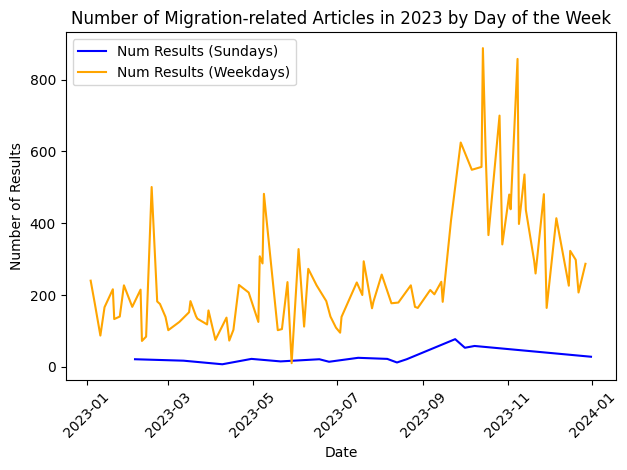

In [9]:
# Plot trend of search results (absolute)
%matplotlib inline
merged_df = merged_df.sort_values(by='Date')
plt.plot(merged_df[merged_df['Weekday'] == "Sunday"]['Date'], merged_df[merged_df['Weekday'] == "Sunday"]['Num_results'],
         label='Num Results (Sundays)', color='blue')
plt.plot(merged_df[merged_df['Weekday'] != "Sunday"]['Date'], merged_df[merged_df['Weekday'] != "Sunday"]['Num_results'],
         label='Num Results (Weekdays)', color='orange')
plt.title('Number of Migration-related Articles in 2023 by Day of the Week')
plt.xlabel('Date')
plt.ylabel('Number of Results')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

We see some spikes of migration-related reporting in February and May, and then a more lively debate in autum and winter of 2023. In a later step, we will also be able to identify the topics of these headlines.
It's evident that in terms of absolute counts, on Sundays we have a lot less articles than during weekdays.

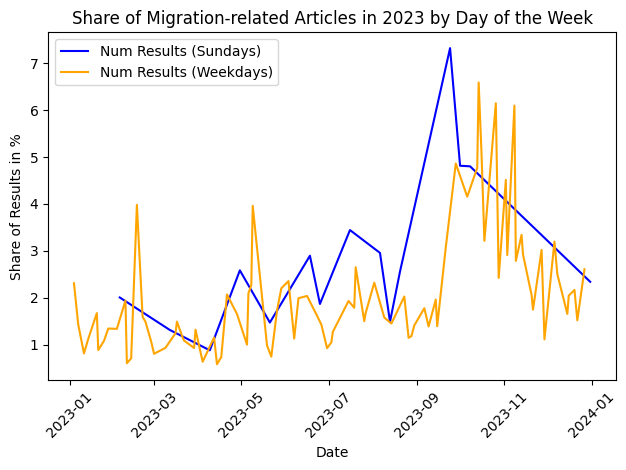

In [10]:
# Plot trend of search results (normalized)
merged_df = merged_df.sort_values(by='Date')
plt.plot(merged_df[merged_df['Weekday'] == "Sunday"]['Date'], merged_df[merged_df['Weekday'] == "Sunday"]['Num_results_normalized'],
         label='Num Results (Sundays)', color='blue')
plt.plot(merged_df[merged_df['Weekday'] != "Sunday"]['Date'], merged_df[merged_df['Weekday'] != "Sunday"]['Num_results_normalized'],
         label='Num Results (Weekdays)', color='orange')
plt.title('Share of Migration-related Articles in 2023 by Day of the Week')
plt.xlabel('Date')
plt.ylabel('Share of Results in %')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

Not surprisingly, the same trend is evident in the normalized data. However, we see that after calculating the shares of articles that on Sundays the percentage is even slightly higher than during weekdays.

We can now save this metadata file and then turn to the content of the news headlines.

In [12]:
# Save metadata file
merged_df = merged_df[['Filename', 'Date', 'Weekday', 'Category', 'Region', 'Num_results', 'Total', 'Num_results_normalized']]
merged_df.to_csv('2023/Do not process/metadata.csv')

## Creating a file with the news headlines and newspaper names

While creating a file containing the headline of a newspaper article sounds straightforward, it's actually a bit tricky. The problem is that in the text files the headlines are duplicated, and sometimes they extend over several lines. We often find the author names mentioned, but overall the text blocks have varying length. So we can't create a simple rule about which text blocks to extract. Hence what follows now is a piecemeal-process of exploring the available text data and trying to create extraction rules that allows us the retrieval of the relevant information without too many errors.

We will loop through each text file and extract the data between some stopwords ("Presseartikel", "Onlineartikel", "Vorschau"), which identify the start and end of a text block for a given article record. But the length and information of the text between these stopwords varies.

In [13]:
# Initialize an empty list to hold article data
article_data_list = []

# Loop through files, create 'Filename' field
for file in files:
    article_data = {}
    article_data['Filename'] = file

    # Initialize variables for block extraction
    start_keywords = ["Presseartikel", "Onlineartikel"]
    end_keyword = "Vorschau"
    blocks = []  # List to hold all blocks of text in this file
    block = []  # To hold the current block of text
    in_block = False  # Flag to indicate if we are currently in a block

    with io.open(f'2023/{file}', 'r', encoding='utf-8') as myFile:
        lines = myFile.readlines()

       # Identify text blocks with article / headline info
        for line in lines:
            line = line.strip()  # Remove leading/trailing whitespace

            # Check for starting keywords
            if any(start in line for start in start_keywords):
                in_block = True  # Start capturing block
                block = [line]  # Start a new block with the starting line

            elif in_block:
                block.append(line)  # Add subsequent lines to the block

            # Check for the ending keyword
            if end_keyword in line and in_block:
                block.append(line)  # Add the ending line to the block
                blocks.append('\n'.join(block))  # Add the full block to blocks list
                block = []  # Reset block for the next capture
                in_block = False  # Reset the flag

    # Add blocks to article_data if any blocks were found
    if blocks:
        article_data['Article'] = blocks  # Store all blocks as a list of strings
        article_data_list.append(article_data)  # Append the article data to the list

# Convert the list of article data dictionaries to a DataFrame
article_df = pd.DataFrame(article_data_list)

print(article_df.head())

                       Filename  \
0  GENIOS - Presse 01032023.txt   
1  GENIOS - Presse 01102023.txt   
2  GENIOS - Presse 02082023.txt   
3  GENIOS - Presse 02112023.txt   
4  GENIOS - Presse 03022023.txt   

                                             Article  
0  [Presseartikel\n\nGöttinger Tageblatt 01.03.20...  
1  [Onlineartikel\n\nsueddeutsche.de 01.10.2023 M...  
2  [Presseartikel\n\nSaale Zeitung 02.08.2023 Min...  
3  [Onlineartikel\n\nsueddeutsche.de 02.11.2023 F...  
4  [Presseartikel\n\nAachener Zeitung 03.02.2023 ...  


At this point, we still have all the article information for a given day stored in one big string. What we eventually want though, is a record for each article on a given day. Thus we want to expand the article relevant data. This is what we do in the next step.

In [14]:
# Initialize a new list to hold the expanded rows
expanded_data_list = []

# Loop through each row in the original DataFrame
for index, row in article_df.iterrows():
    filename = row['Filename']
    articles = row['Article']

    # For each article in the list of articles, create a new row
    for article in articles:
        expanded_data_list.append({'Filename': filename, 'Article': article})

# Convert the expanded data list to a new DataFrame
expanded_article_df = pd.DataFrame(expanded_data_list)
print(expanded_article_df.shape)
print(expanded_article_df.head())

(21546, 2)
                       Filename  \
0  GENIOS - Presse 01032023.txt   
1  GENIOS - Presse 01032023.txt   
2  GENIOS - Presse 01032023.txt   
3  GENIOS - Presse 01032023.txt   
4  GENIOS - Presse 01032023.txt   

                                             Article  
0  Presseartikel\n\nGöttinger Tageblatt 01.03.202...  
1  Presseartikel\n\nEichsfelder Tageblatt 01.03.2...  
2  Presseartikel\n\nPeiner Allgemeine Zeitung 01....  
3  Onlineartikel\n\nFAZ.NET 01.03.2023 Der Traum ...  
4  Onlineartikel\n\nWELT ONLINE 01.03.2023 Verfah...  


We successfully expanded the article information. Now, instead of 104 rows (2 days per week, 52 weeks), we have a DataFrame holding 21546 rows. That's a bit more data to work with now. The only problem is that we have to give structure to it.

## Data cleaning

We now need to split up the text block (string) for each article into different parts. Each of these parts contains different pieces of information that we will extract. After splitting, the data will be stored in a list. We can access each element of this list separately and store it. Some information, like the newspaper name or the article type are always at the same position. These can be extracted easily.

In [15]:
## Data cleaning ##
# Each block needs to be split up in different relevant pieces of information #

# Split up text block
expanded_article_df['string'] = expanded_article_df['Article'].str.split("\n")

# First element in new string column will contain the type of article
expanded_article_df['Article_type'] = expanded_article_df.apply(lambda x: x['string'][0], axis=1)

# Third element contains the source (news paper name)
expanded_article_df['Source'] = expanded_article_df.apply(lambda x: x['string'][2], axis=1)
expanded_article_df['Source'] = expanded_article_df['Source'].str.replace(r'\s*\d{2}\.\d{2}\.\d{4}.*$', '', regex=True).str.strip()

print(expanded_article_df.head())

                       Filename  \
0  GENIOS - Presse 01032023.txt   
1  GENIOS - Presse 01032023.txt   
2  GENIOS - Presse 01032023.txt   
3  GENIOS - Presse 01032023.txt   
4  GENIOS - Presse 01032023.txt   

                                             Article  \
0  Presseartikel\n\nGöttinger Tageblatt 01.03.202...   
1  Presseartikel\n\nEichsfelder Tageblatt 01.03.2...   
2  Presseartikel\n\nPeiner Allgemeine Zeitung 01....   
3  Onlineartikel\n\nFAZ.NET 01.03.2023 Der Traum ...   
4  Onlineartikel\n\nWELT ONLINE 01.03.2023 Verfah...   

                                              string   Article_type  \
0  [Presseartikel, , Göttinger Tageblatt 01.03.20...  Presseartikel   
1  [Presseartikel, , Eichsfelder Tageblatt 01.03....  Presseartikel   
2  [Presseartikel, , Peiner Allgemeine Zeitung 01...  Presseartikel   
3  [Onlineartikel, , FAZ.NET 01.03.2023 Der Traum...  Onlineartikel   
4  [Onlineartikel, , WELT ONLINE 01.03.2023 Verfa...  Onlineartikel   

                      Sou

Retrieving the headlines, however, is tricky. So that is why we start by measuring the length of lists containing the split text parts. We then develop a strategy for data extraction for each of these parts separately.

In [17]:
# Determine the length of lists in expanded_article_df['string']
expanded_article_df['list_length'] = expanded_article_df.apply(lambda x: len(x['string']), axis=1)

# Display distribution of different lengths
print('Length of split string lists:')
print(expanded_article_df['list_length'].value_counts())
print('\n')

# Print samples of 'string' for different lengths
pd.set_option('display.max_colwidth', None)
print('Lists of length 6:')
print(expanded_article_df[expanded_article_df['list_length'] == 6]['string'].sample( n=10, random_state=42))
print('\n')
# third last element is the headline

print('Lists of length 7:')
print(expanded_article_df[expanded_article_df['list_length'] == 7]['string'].sample( n=10, random_state=42))
print('\n')
# fourth last element is the headline

print('Lists of length 8:')
print(expanded_article_df[expanded_article_df['list_length'] == 8]['string'].sample( n=10, random_state=42))
print('\n')
# fourth last element is the headline

print('Lists of length 9:')
print(expanded_article_df[expanded_article_df['list_length'] == 9]['string'].sample( n=10, random_state=42))
print('\n')
# complex solution needed

pd.reset_option('display.max_colwidth')

Length of split string lists:
list_length
7     9734
6     8156
8     3112
9      255
10     148
12      57
11      55
13      24
14       3
18       1
15       1
Name: count, dtype: int64


Lists of length 6:
11412                                                    [Presseartikel, , Schleswig-Holsteinische Landeszeitung 16.10.2023 Ohne Titel, Ohne Titel, Vorschau, Vorschau]
3232                              [Presseartikel, , Holsteinischer Courier 06.10.2023 Keine Zeit für eine Atempause, Keine Zeit für eine Atempause, Vorschau, Vorschau]
18788              [Presseartikel, , Neue Westfälische 27.11.2023 Grüne geben Spitzenleuten Rückendeckung, Grüne geben Spitzenleuten Rückendeckung, Vorschau, Vorschau]
4479                                      [Presseartikel, , Neue Ruhr/Neue Rhein Zeitung 08.12.2023 ...und das Elternhaus?, ...und das Elternhaus?, Vorschau, Vorschau]
2501              [Presseartikel, , Westerwälder Zeitung 06.05.2023 Scholz wirbt um kenianische Fachkräfte, Scholz wir

Looking at the lists of different lengths, we can see that for lists up to length 8, each list element is usually in a fixed place and contains the information that we are looking for. The position of this information might be different, but in principle we can extract it in a similar way as we did for the metadata.

But for those lists of length 9 or more, we see that there are often problems with long article information, extending about several lines, duplicated fields and mixing with author names. For those records, we need to apply various operations. Without going nto all the details, we basically take the lists, retain only the unique fields and make sure that they stay in the same order. We then split off information that either belongs to the newspaper name or is author information. We do that by identifying certain characters (numbers of specific words) that help us determine when a certain information is revealed in a string. This will not give us the correct headline for most cases, but it's not completely error-free.

We start with the processing of the complicated cases and then turn to the simple cases.


In [18]:
# Extract headline for list_length > 8
# Extract unique elements from list in column 'string'
def unique_everseen(iterable, key=None):
    seen = set()
    seen_add = seen.add
    if key is None:
        for element in filterfalse(seen.__contains__, iterable):
            seen_add(element)
            yield element
    else:
        for element in iterable:
            k = key(element)
            if k not in seen:
                seen_add(k)
                yield element


def process_article(row):
    # Check if list_length > 8
    if row['list_length'] > 8:
        # Extract unique elements
        unique_items = list(unique_everseen(row['string']))

        # Retain only the part after the date
        unique_items = [extract_after_date(elem) for elem in unique_items]

        # Remove duplicates again
        unique_items = list(unique_everseen(unique_items))

        # Retain only specific elements
        unique_items = unique_items[2:-1] if len(unique_items) > 3 else unique_items

        # Extract headline
        headline = extract_headline(unique_items)

        return unique_items, headline
    else:
        return row['string'], None  # Or any other default behavior


# Define the function to retain only the part after the date
def extract_after_date(text):
    match = re.search(r'\d{2}\.\d{2}\.\d{4}', text)
    if match:
        return text[match.end():].strip()  # Remove leading spaces
    return text


# Define function to extract headline
def extract_headline(lst):
    if isinstance(lst, list):
        joined = ' '.join(lst)
        cleaned = re.sub(r'["„“»]', '', joined)
        cleaned = re.sub(r'\s+', ' ', cleaned)  # Normalize spaces
        cleaned = re.split(r'\b(?:von|Fotos|Text|Autor|Interview|und|n/)\b', cleaned)[0]
        parts = re.split(r'[,:;.]', cleaned)
        unique_parts = list(dict.fromkeys([part.strip() for part in parts]))
        headline = ' '.join(unique_parts).strip()
        headline = ' '.join(dict.fromkeys(headline.split()))  # Remove duplicates
        return headline
    return lst


# Apply the processing function to the DataFrame
expanded_article_df[['unique', 'Headline']] = expanded_article_df.apply(process_article, axis=1, result_type='expand')

We can now process the simpler cases. An additional challenge are lists of length 7. Here we often find author information, where we actually want the headline content. There are special words that give these cases away, and we treat these separately below.

In [19]:
# Extract headline for list_length == 6
expanded_article_df.loc[expanded_article_df['list_length'] == 6, 'Headline'] = expanded_article_df[expanded_article_df['list_length'] == 6].apply(lambda x: x['string'][-3], axis=1)

# Extract headline for list_length == 7
# Create a function to compare the 4th-last and 3rd-last elements, and handle the "von" condition

# List of exclusion words
exclusion_words = ["von", "interview", "fotos", "text", "abendblatt", "aust", "decker", "vates", "jacqueline", "westermann", "raether"]
def get_headline(row):
    third_last = row['string'][-3]
    fourth_last = row['string'][-4]

    # If the third_last contains "von" or "VON", return the fourth_last element
    if any(word in third_last.lower() for word in exclusion_words) or third_last.isupper():
        return fourth_last

    # Otherwise, return the longer string
    if len(third_last) > len(fourth_last):
        return third_last
    else:
        return fourth_last

# Apply the function to rows where 'list_length' == 7
expanded_article_df.loc[expanded_article_df['list_length'] == 7, 'Headline'] = expanded_article_df[expanded_article_df['list_length'] == 7].apply(get_headline, axis=1)

# Extract headline for list_length == 8
expanded_article_df.loc[expanded_article_df['list_length'] == 8, 'Headline'] = expanded_article_df[expanded_article_df['list_length'] == 8].apply(lambda x: x['string'][-4], axis=1)


This certainly was a significant amount of work! But finally, here is our cleaned DataFrame containing the relevant article-level data.

In [20]:
# Cleaned DataFrame
expanded_article_df.drop(columns=['Article', 'string', 'unique', 'list_length', 'unique'], inplace=True)
expanded_article_df.to_csv('2023/Do not process/articles.csv')
print(expanded_article_df.head())

                       Filename   Article_type                     Source  \
0  GENIOS - Presse 01032023.txt  Presseartikel        Göttinger Tageblatt   
1  GENIOS - Presse 01032023.txt  Presseartikel      Eichsfelder Tageblatt   
2  GENIOS - Presse 01032023.txt  Presseartikel  Peiner Allgemeine Zeitung   
3  GENIOS - Presse 01032023.txt  Onlineartikel                    FAZ.NET   
4  GENIOS - Presse 01032023.txt  Onlineartikel                WELT ONLINE   

                                            Headline  
0                  Migration: Krise kostet viel Geld  
1                  Migration: Krise kostet viel Geld  
2                  Migration: Krise kostet viel Geld  
3  Der Traum von mehr Geld - und der deutschen Au...  
4  Verfahren gegen Äbtissin in Kirchenasyl-Prozes...  


## Visualize most relevant words in migration news headlines as wordcloud 

We are finally ready to visualize our data as wordcloud!
Note that we are not stripping the data of all connecting words or tokenize the text data at this point. 
However some words should be removed as they do not really cotain any relevant information. We do this below and create a wordcloud for the news headlines throughout the year.

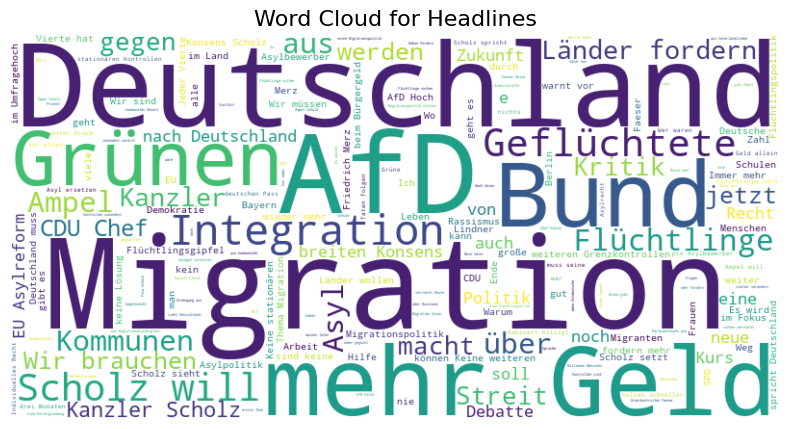

In [21]:
# Combine all headlines into a single string
headlines_combined = ' '.join(expanded_article_df['Headline'].dropna())

# Ignore these words
custom_stopwords = set(STOPWORDS).union({"nicht", "au", "nur", "den", "presse", "das", "sie", "da", "als", "ein", "sich", "mit", "und", "zu", "ist", "wie", "um", "dem", "vom", "auf", "für", "die", "der", "ohne", "titel", "bei"})  

# Create WordCloud object
wordcloud = WordCloud(width=800, height=400,
                      background_color='white',
                      colormap='viridis',
                      stopwords=custom_stopwords,
                      random_state=42).generate(headlines_combined)

# Plotting and saving wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Headlines', fontsize=16)
wordcloud.to_file('wordcloud_headlines_v2.png')
plt.show()

Well, it seems that the most frequently mentioned words in migration-related news headlines were "Deutschland", "AfD", "Migration", and "mehr Geld". If we look at the slightly smaller words we also see "Geflüchtete", "Flüchtline", "Kommunen", "Länder fordern".
A lot of the debate in 2023 focused on refugees, for which the Federal States and the municipalities are responsible to provide with housing, schooling etc. While the federal level provides a fixed share of funding, this was seen as insufficient. So basically the states and municipalities demanded more money from the federal level. The political party who seems to have been involved the strongest (or at least mentioned most frequently) was the far-right / extremist "Alternative für Deutschland" (AfD). 

After this overview we can also create a wordcloud for every month and see what dominated the headlines throughout the year.

## Plot word clouds by month

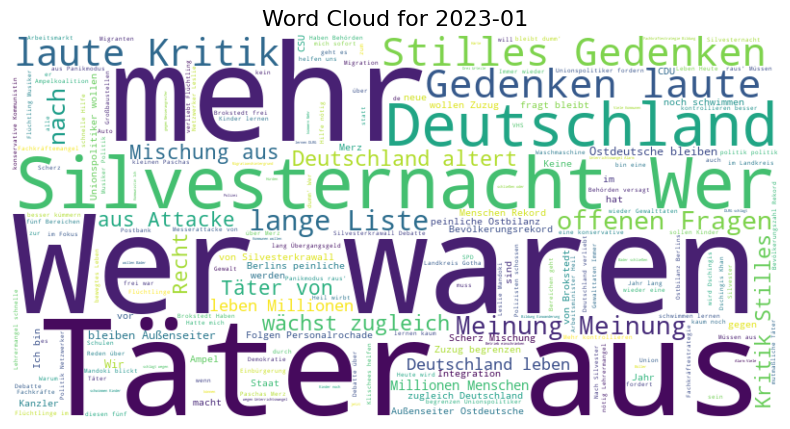

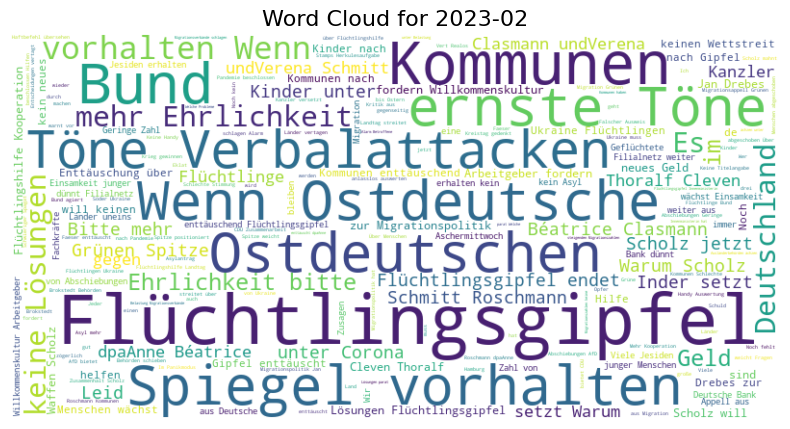

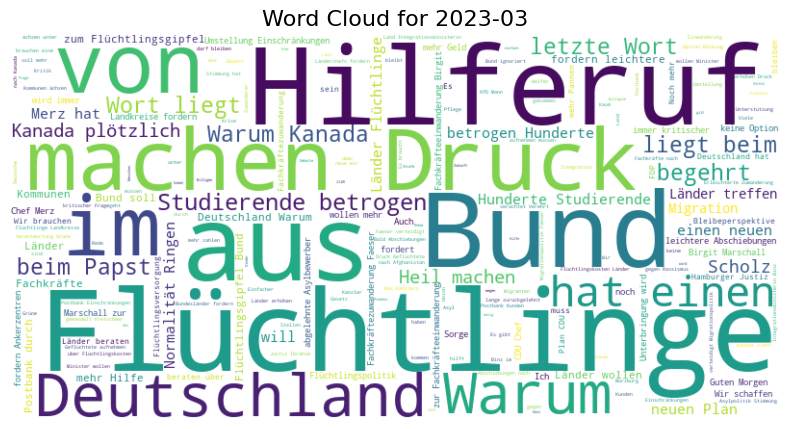

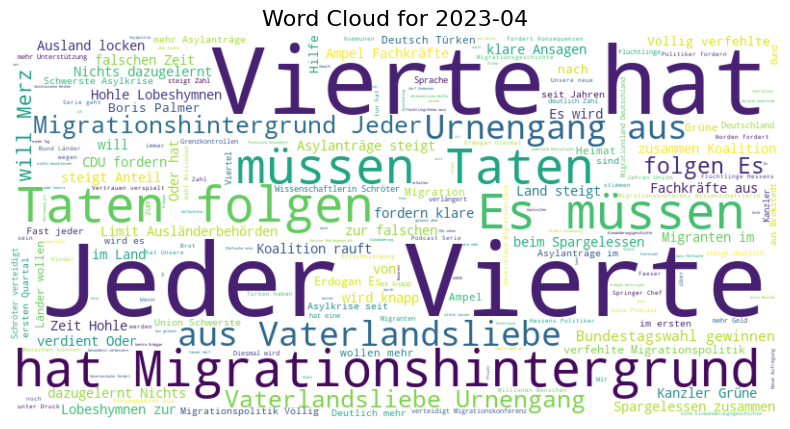

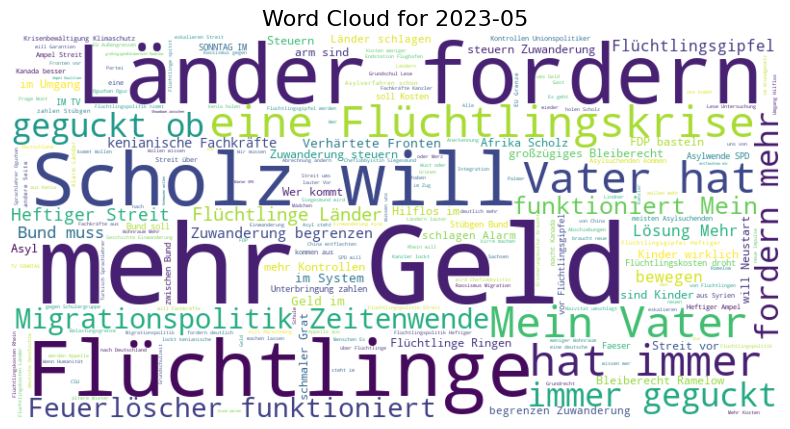

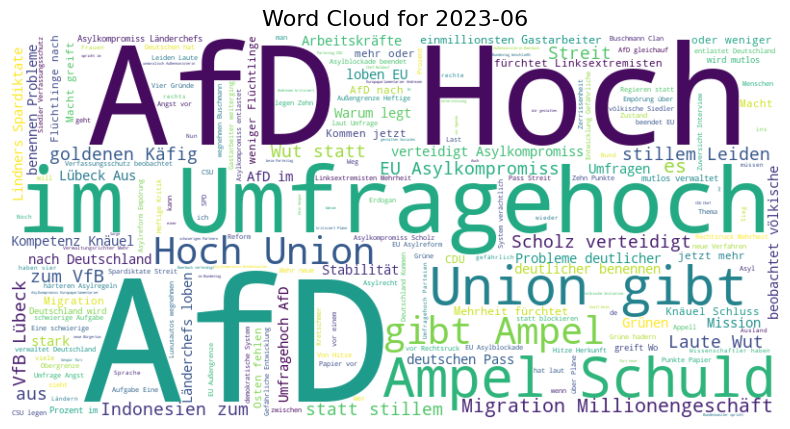

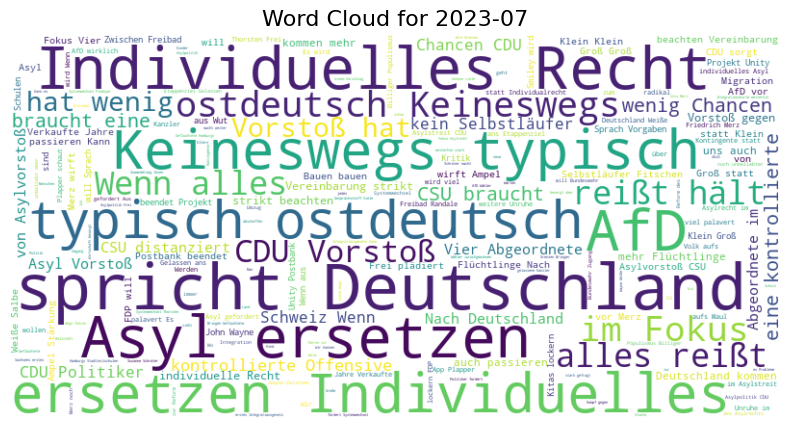

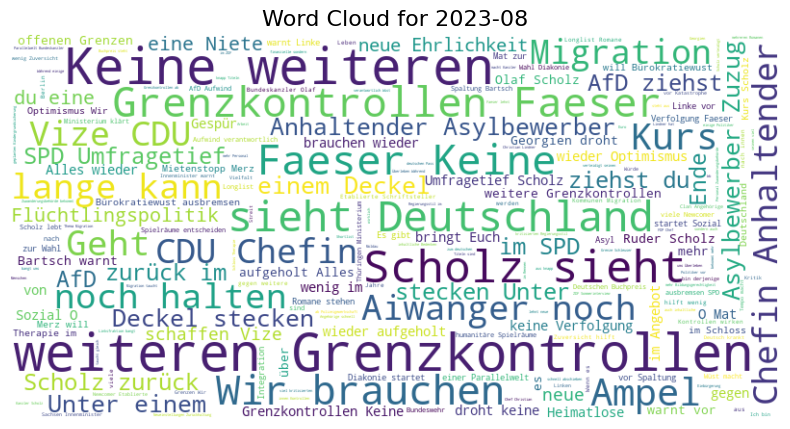

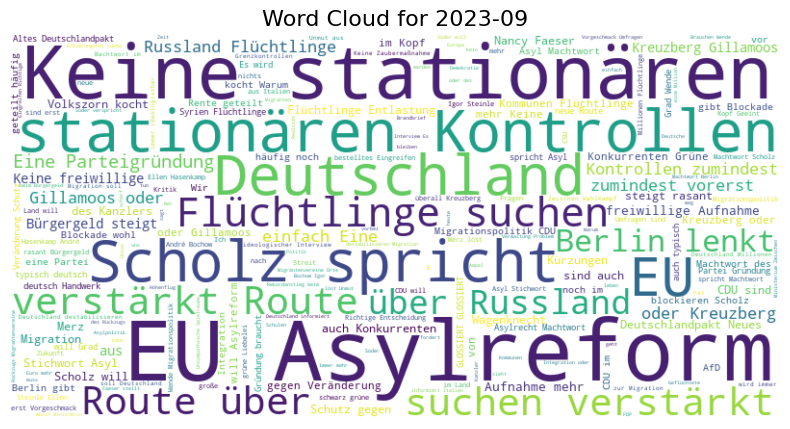

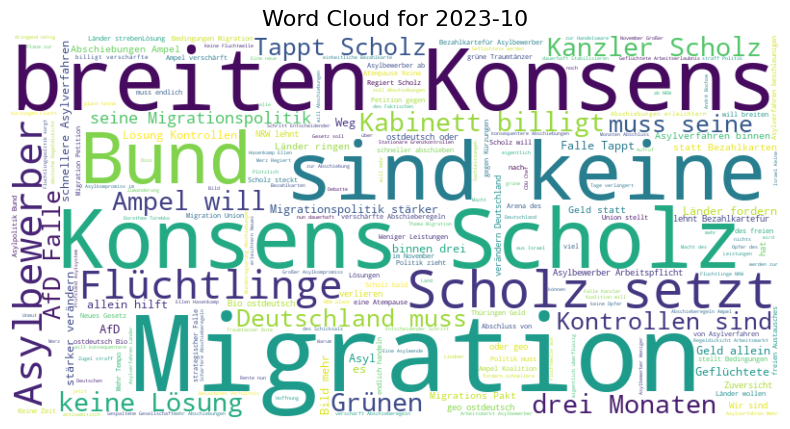

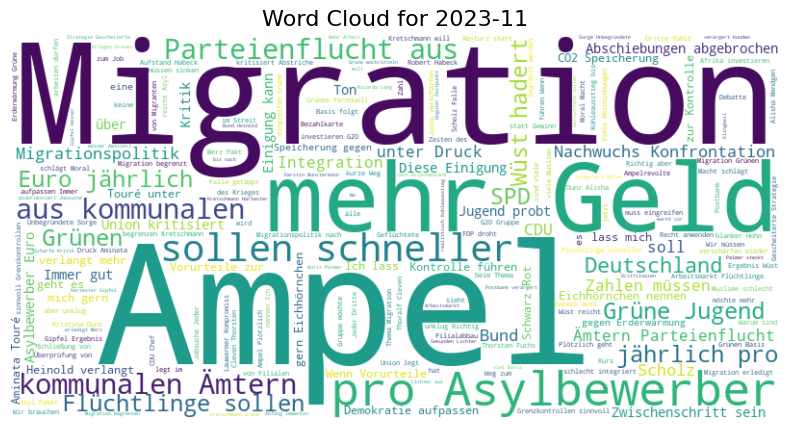

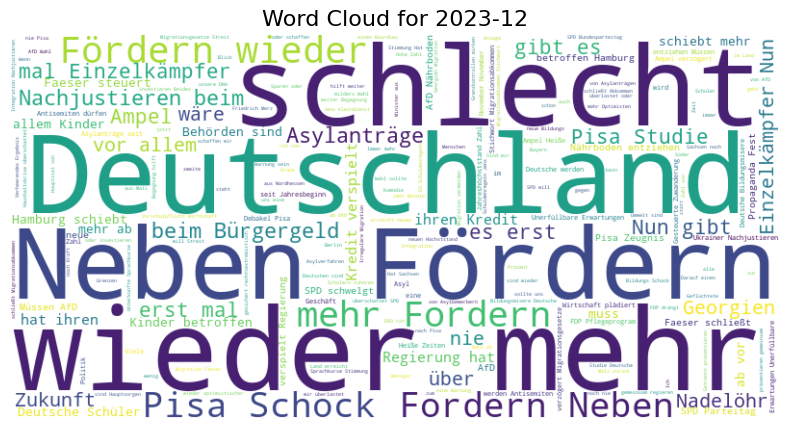

In [23]:
# Wordclouds by month

# Merge with metadata

merged_df = pd.read_csv('2023/Do not process/metadata_current.csv')
expanded_article_df = pd.read_csv('2023/Do not process/articles.csv')

combined_df = pd.merge(expanded_article_df, merged_df, on='Filename', how='left')

# Convert the Date column to datetime format
combined_df['Date'] = pd.to_datetime(combined_df['Date'])

# Create a new column for month-year
combined_df['Month'] = combined_df['Date'].dt.to_period('M')  # This will give you Year-Month format

# Create a word cloud for each month
for month, group in combined_df.groupby('Month'):
    # Combine all headlines for the month
    headlines_combined = ' '.join(group['Headline'].dropna())

    # Ignore these words
    custom_stopwords = set(STOPWORDS).union(
        {"nicht", "au", "nur", "den", "presse", "das", "sie", "da", "als", "ein", "sich", "mit", "und", "zu", "ist",
         "wie", "um", "dem", "vom", "auf", "für", "die", "der", "ohne", "titel",
         "bei"})

    # Create WordCloud object with stopwords
    wordcloud = WordCloud(width=800, height=400,
                          background_color='white',
                          colormap='viridis',
                          stopwords=custom_stopwords,
                          random_state=42).generate(headlines_combined)

    # Plotting and saving wordclouds
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'Word Cloud for {month}', fontsize=16)
    wordcloud_file_path = f'wordcloud_{month}.png'  # Specify your desired file path and name
    wordcloud.to_file(wordcloud_file_path)  # Save the image
    plt.show()

For sake of brevity, I will not describe the word cloud in every month. But we can easily trace the public debate about the migration topic in 2023. The year starts with discussion about the New Year's Eve 2022, which was marked by violence. East Germany comes into focus and the first "Refugee summit". Spring is dominated by reporting about the number of people with migrant background, and the states voice their demands for more money. The AfD is making the headlines in June, as they reach a high in the polls. July sees a debate about asylum rights, while border checks are being discussed and introduced over the summer months. The government declares a consensus decision about the demands raised by the states, and more money per asylum seeker is paid to states and municipalities in November. The news in December are dominated by worsened results in the OECD's PISA education assessment. 

## Summary

In this small project we extracted information from migration-related newspaper headlines in German newspapers in 2023. After extended data processing and cleaning we were able to visualize the most frequently used words for the complete year, and we also were able to track the migration debate on a monthly basis.

As the data contains more information about local newspapers, we can also track regional results or apply further techniques like topic modelling to the headlines. This would allow to identify the main dimensions of topics being reported on. Further work could also explore in how far the news reporting affected party preferences measured in nationwide opinion polls.